In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import zipfile, glob, json
import matplotlib.pyplot as plt
import statsmodels.api as sm
import datetime
import data_processing
from sqlalchemy import create_engine
from scipy.stats import scoreatpercentile
from sklearn.preprocessing import Imputer
pd.options.display.max_columns = 500
pd.options.display.max_rows = 10000
%matplotlib inline

In [3]:
df_sfdata_import = pd.read_csv('../data/sfdata/Existing_Commercial_Buildings_Energy_Performance_Ordinance_Report.csv')

In [4]:
df_sfdata_import.head(3)

,Parcel(s),Building Name,Building Address,Postal Code,Full.Address,Floor Area,Property Type - Self Selected,PIM Link,Benchmark 2010 Status,Benchmark 2011 Status,Benchmark 2012 Status,Benchmark 2013 Status,Benchmark 2014 Status,Benchmark 2015 Status,Energy Audit Due Date,Energy Audit Status,2011 ENERGY STAR Score,2011 Site EUI (kBtu/ft2),2011 Source EUI (kBtu/ft2),2011 Percent Better than National Median Site EUI,2011 Percent Better than National Median Source EUI,2011 Total GHG Emissions (Metric Tons CO2e),2011 Total GHG Emissions Intensity (kgCO2e/ft2),2011 Weather Normalized Site EUI (kBtu/ft2),2011 Weather Normalized Source EUI (kBtu/ft2),2012 ENERGY STAR Score,2012 Site EUI (kBtu/ft2),2012 Source EUI (kBtu/ft2),2012 Percent Better than National Median Site EUI,2012 Percent Better than National Median Source EUI,2012 Total GHG Emissions (Metric Tons CO2e),2012 Total GHG Emissions Intensity (kgCO2e/ft2),2012 Weather Normalized Site EUI (kBtu/ft2),2012 Weather Normalized Source EUI (kBtu/sq.ft),2013 ENERGY STAR Score,2013 Site EUI (kBtu/ft2),2013 Source EUI (kBtu/ft2),2013 Percent Better than National Median Site EUI,2013 Percent Better than National Median Source EUI,2013 Total GHG Emissions (Metric Tons CO2e),2013 Total GHG Emissions Intensity (kgCO2e/ft2),2013 Weather Normalized Site EUI (kBtu/ft2),2013 Weather Normalized Source EUI (kBtu/ft2),2014 ENERGY STAR Score,2014 Site EUI (kBtu/ft2),2014 Source EUI (kBtu/ft2),2014 Percent Better than National Median Site EUI,2014 Percent Better than National Median Source EUI,2014 Total GHG Emissions (Metric Tons CO2e),2014 Total GHG Emissions Intensity (kgCO2e/ft2),2014 Weather Normalized Site EUI (kBtu/ft2),2014 Weather Normalized Source EUI (kBtu/ft2),2015 ENERGY STAR Score,2015 Site EUI (kBtu/ft2),2015 Source EUI (kBtu/ft2),2015 Percent Better than National Median Site EUI,2015 Percentage Better than National Median Source EUI,2015 Total GHG Emissions (Metric Tons CO2e),2015 Total GHG Emissions Intensity (kgCO2e/ft2),2015 Weather Normalized Site EUI (kBtu/ft2),2015 Weather Normalized Source EUI (kBtu/ft2)
0,0010/001,2801 Leavenworth Street,2801 LEAVENWORTH ST,94109,"2801 LEAVENWORTH ST\nSan Francisco, CA 94109\n...",133675,Office,http://propertymap.sfplanning.org/?&search=001...,Violation - Did Not Comply,Complied,Complied,Complied,Complied,Complied,11/15/12,Complied,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,81,71.0,149.9,-34.5,NaN,696.40,NaN,70.7,149.7,74,81.3,NaN,-26.2,-26.2,786.5,5.7,81.6,167.2,56,73.4,158.5,-6.5,-6.5,668.9,5.0,77.1,162.4,72,72,153.9,-23,-23,653.2,4.9,73.7,155.6
1,0010/002,Argonaut Hotel-SV,495 Jefferson St,94109,"495 Jefferson St\nSan Francisco, CA 94109\n(37...",180450,Hotel,http://propertymap.sfplanning.org/?&search=001...,Complied,Complied,Complied,Complied,Complied,Upcoming,4/1/14,Complied,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,95,55.9,115.1,-48.0,NaN,704.18,NaN,55.9,115.1,78,67.9,NaN,-25.3,-25.3,844.7,4.7,67.9,136.1,79,63.6,129.5,-26.5,-26.5,763.1,4.2,63.6,129.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0011/007,Anchorage Office,2800 LEAVENWORTH ST,94133,"2800 LEAVENWORTH ST\nSan Francisco, CA 94133\n...",121408,Hotel,http://propertymap.sfplanning.org/?&search=001...,Violation - Insufficient Data,Violation - Insufficient Data,Complied,Complied,Complied,Upcoming,11/15/12,Complied,NaN,NaN,NaN,NaN,NaN,NaN,6.3,NaN,NaN,NaN,92.2,196.6,59.7,59.7,759.20,6.3,92.2,196.6,NaN,92.4,NaN,60.2,60.2,761.4,6.3,92.4,197.2,NaN,73.8,173.3,40.8,40.8,634.3,5.2,73.8,173.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
df_sfdata = df_sfdata_import.copy()

In [39]:
df_sfdata = df_sfdata[['Building Name', 'Building Address', 'Postal Code', 'Floor Area', '2014 ENERGY STAR Score',
                                '2014 Site EUI (kBtu/ft2)', '2014 Source EUI (kBtu/ft2)', '2014 Total GHG Emissions (Metric Tons CO2e)',
                                '2014 Total GHG Emissions Intensity (kgCO2e/ft2)']]

In [40]:
df_sfdata.head(3)

,Building Name,Building Address,Postal Code,Floor Area,2014 ENERGY STAR Score,2014 Site EUI (kBtu/ft2),2014 Source EUI (kBtu/ft2),2014 Total GHG Emissions (Metric Tons CO2e),2014 Total GHG Emissions Intensity (kgCO2e/ft2)
0,2801 Leavenworth Street,2801 LEAVENWORTH ST,94109,133675,56,73.4,158.5,668.9,5.0
1,Argonaut Hotel-SV,495 Jefferson St,94109,180450,79,63.6,129.5,763.1,4.2
2,Anchorage Office,2800 LEAVENWORTH ST,94133,121408,NaN,73.8,173.3,634.3,5.2


In [41]:
df_sfdata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1721 entries, 0 to 1720
Data columns (total 9 columns):
Building Name                                      1721 non-null object
Building Address                                   1721 non-null object
Postal Code                                        1721 non-null object
Floor Area                                         1721 non-null int64
2014 ENERGY STAR Score                             730 non-null float64
2014 Site EUI (kBtu/ft2)                           1073 non-null float64
2014 Source EUI (kBtu/ft2)                         1073 non-null float64
2014 Total GHG Emissions (Metric Tons CO2e)        1072 non-null float64
2014 Total GHG Emissions Intensity (kgCO2e/ft2)    1072 non-null float64
dtypes: float64(5), int64(1), object(3)
memory usage: 134.5+ KB


In [42]:
df_sfdata.head()

,Building Name,Building Address,Postal Code,Floor Area,2014 ENERGY STAR Score,2014 Site EUI (kBtu/ft2),2014 Source EUI (kBtu/ft2),2014 Total GHG Emissions (Metric Tons CO2e),2014 Total GHG Emissions Intensity (kgCO2e/ft2)
0,2801 Leavenworth Street,2801 LEAVENWORTH ST,94109,133675,56,73.4,158.5,668.9,5.0
1,Argonaut Hotel-SV,495 Jefferson St,94109,180450,79,63.6,129.5,763.1,4.2
2,Anchorage Office,2800 LEAVENWORTH ST,94133,121408,NaN,73.8,173.3,634.3,5.2
3,Anchorage Garage,500 BEACH ST,94133,198525,NaN,27.5,76.9,419.6,2.1
4,211 Jefferson St,2739 TAYLOR ST,94133,40052,NaN,NaN,NaN,NaN,NaN


In [43]:
numeric_cols = ['Floor Area', '2014 ENERGY STAR Score',
                                '2014 Site EUI (kBtu/ft2)', '2014 Source EUI (kBtu/ft2)',
                                '2014 Total GHG Emissions Intensity (kgCO2e/ft2)']

In [44]:
df_sfdata[numeric_cols] = df_sfdata[numeric_cols].apply(lambda x: x.fillna(x.mean()),axis=0)

In [45]:
df_sfdata.head()

,Building Name,Building Address,Postal Code,Floor Area,2014 ENERGY STAR Score,2014 Site EUI (kBtu/ft2),2014 Source EUI (kBtu/ft2),2014 Total GHG Emissions (Metric Tons CO2e),2014 Total GHG Emissions Intensity (kgCO2e/ft2)
0,2801 Leavenworth Street,2801 LEAVENWORTH ST,94109,133675,56.000000,73.400000,158.500000,668.9,5.000000
1,Argonaut Hotel-SV,495 Jefferson St,94109,180450,79.000000,63.600000,129.500000,763.1,4.200000
2,Anchorage Office,2800 LEAVENWORTH ST,94133,121408,70.621918,73.800000,173.300000,634.3,5.200000
3,Anchorage Garage,500 BEACH ST,94133,198525,70.621918,27.500000,76.900000,419.6,2.100000
4,211 Jefferson St,2739 TAYLOR ST,94133,40052,70.621918,67.901678,155.354427,NaN,4.767071


In [47]:
mean_ei = df_sfdata['2014 Total GHG Emissions Intensity (kgCO2e/ft2)'].mean()

In [51]:
df_sfdata['2014 Total GHG Emissions (Metric Tons CO2e)'] = df_sfdata['2014 Total GHG Emissions (Metric Tons CO2e)'].fillna((df_sfdata['Floor Area'] * mean_ei *.001),axis=0)

In [54]:
df_sfdata.head()

,Building Name,Building Address,Postal Code,Floor Area,2014 ENERGY STAR Score,2014 Site EUI (kBtu/ft2),2014 Source EUI (kBtu/ft2),2014 Total GHG Emissions (Metric Tons CO2e),2014 Total GHG Emissions Intensity (kgCO2e/ft2)
0,2801 Leavenworth Street,2801 LEAVENWORTH ST,94109,133675,56.000000,73.400000,158.500000,668.900000,5.000000
1,Argonaut Hotel-SV,495 Jefferson St,94109,180450,79.000000,63.600000,129.500000,763.100000,4.200000
2,Anchorage Office,2800 LEAVENWORTH ST,94133,121408,70.621918,73.800000,173.300000,634.300000,5.200000
3,Anchorage Garage,500 BEACH ST,94133,198525,70.621918,27.500000,76.900000,419.600000,2.100000
4,211 Jefferson St,2739 TAYLOR ST,94133,40052,70.621918,67.901678,155.354427,190.930724,4.767071


In [52]:
df_sfdata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1721 entries, 0 to 1720
Data columns (total 9 columns):
Building Name                                      1721 non-null object
Building Address                                   1721 non-null object
Postal Code                                        1721 non-null object
Floor Area                                         1721 non-null int64
2014 ENERGY STAR Score                             1721 non-null float64
2014 Site EUI (kBtu/ft2)                           1721 non-null float64
2014 Source EUI (kBtu/ft2)                         1721 non-null float64
2014 Total GHG Emissions (Metric Tons CO2e)        1721 non-null float64
2014 Total GHG Emissions Intensity (kgCO2e/ft2)    1721 non-null float64
dtypes: float64(5), int64(1), object(3)
memory usage: 134.5+ KB


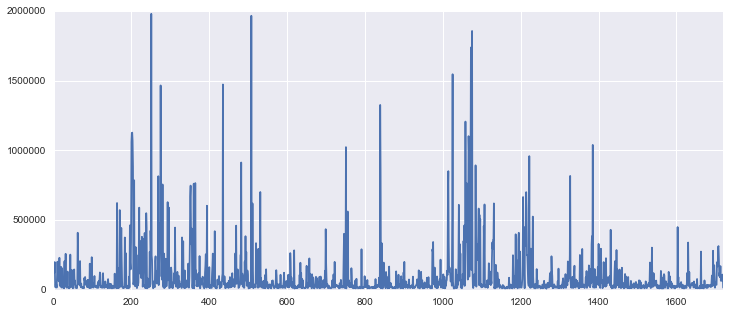

In [61]:
df_sfdata['Floor Area'].plot(figsize=(12,5))

In [66]:
df_sfdata.sort_values('Floor Area',ascending=False)

,Building Name,Building Address,Postal Code,Floor Area,2014 ENERGY STAR Score,2014 Site EUI (kBtu/ft2),2014 Source EUI (kBtu/ft2),2014 Total GHG Emissions (Metric Tons CO2e),2014 Total GHG Emissions Intensity (kgCO2e/ft2)
251,555 California,555 CALIFORNIA ST,94104,1978104,68.000000,83.400000,204.700000,11499.500000,6.400000
508,Hilton San Francisco Union Square,333 OFARRELL ST,94102,1964250,45.000000,68.800000,138.100000,9363.719007,4.767071
1075,One Market Plaza,1 MARKET ST,94105,1855327,70.621918,67.901678,155.354427,8844.475343,4.767071
1072,PGE-GO Complex 102_245M_77BL,245 Market Street,94105,1737113,95.000000,71.200000,191.600000,8479.000000,5.400000
1025,337F2-San Francisco Moscone Marriott,765 MARKET ST,94103,1545220,42.000000,67.100000,156.800000,7318.700000,4.700000
435,Westin St. Francis Hotel,335 POWELL ST,94102,1471800,65.000000,65.400000,120.900000,6488.500000,4.600000
275,101 California,101 CALIFORNIA ST,94111,1464955,94.000000,41.900000,123.000000,4564.900000,3.300000
839,1455 Market Street,1455 Market Street,94103,1325000,70.621918,88.400000,223.600000,7605.400000,6.500000
1058,525 Market Street,525 MARKET ST,94105,1205848,91.000000,49.800000,139.800000,4542.900000,3.800000
202,Three Embarcadero Center,3 EMBARCADERO CENTER,94111,1126589,85.000000,89.800000,211.800000,4944.200000,6.400000


## Energy Calculations

In [55]:
reduction_factor = 0.05
energy_cost_index = 2.04
hvac_factor = 0.4

In [56]:
df_sfdata[['Floor Area','2014 Total GHG Emissions (Metric Tons CO2e)']].sum()

Floor Area                                     1.615135e+08
2014 Total GHG Emissions (Metric Tons CO2e)    7.431605e+05
dtype: float64

In [57]:
1.615135e+08, 7.431605e+05

(161513500.0, 743160.5)

In [67]:
df_sfdata['total_energy'] = df_sfdata['Floor Area'] * df_sfdata['2014 Source EUI (kBtu/ft2)']

In [69]:
df_sfdata['energy_saved'] = df_sfdata['total_energy'] * reduction_factor * hvac_factor

In [70]:
df_sfdata['cost_saved'] = df_sfdata['energy_saved'] * energy_cost_index

In [71]:
df_sfdata['co2_saved'] = df_sfdata['2014 Total GHG Emissions (Metric Tons CO2e)'] * reduction_factor * hvac_factor

In [73]:
df_sfdata.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,...,1471,1472,1473,1474,1475,1476,1477,1478,1479,1480,1481,1482,1483,1484,1485,1486,1487,1488,1489,1490,1491,1492,1493,1494,1495,1496,1497,1498,1499,1500,1501,1502,1503,1504,1505,1506,1507,1508,1509,1510,1511,1512,1513,1514,1515,1516,1517,1518,1519,1520,1521,1522,1523,1524,1525,1526,1527,1528,1529,1530,1531,1532,1533,1534,1535,1536,1537,1538,1539,1540,1541,1542,1543,1544,1545,1546,1547,1548,1549,1550,1551,1552,1553,1554,1555,1556,1557,1558,1559,1560,1561,1562,1563,1564,1565,1566,1567,1568,1569,1570,1571,1572,1573,1574,1575,1576,1577,1578,1579,1580,1581,1582,1583,1584,1585,1586,1587,1588,1589,1590,1591,1592,1593,1594,1595,1596,1597,1598,1599,1600,1601,1602,1603,1604,1605,1606,1607,1608,1609,1610,1611,1612,1613,1614,1615,1616,1617,1618,1619,1620,1621,1622,1623,1624,1625,1626,1627,1628,1629,1630,1631,1632,1633,1634,1635,1636,1637,1638,1639,1640,1641,1642,1643,1644,1645,1646,1647,1648,1649,1650,1651,1652,1653,1654,1655,1656,1657,1658,1659,1660,1661,1662,1663,1664,1665,1666,1667,1668,1669,1670,1671,1672,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682,1683,1684,1685,1686,1687,1688,1689,1690,1691,1692,1693,1694,1695,1696,1697,1698,1699,1700,1701,1702,1703,1704,1705,1706,1707,1708,1709,1710,1711,1712,1713,1714,1715,1716,1717,1718,1719,1720
Building Name,2801 Leavenworth Street,Argonaut Hotel-SV,Anchorage Office,Anchorage Garage,211 Jefferson St,DiMaggio Building,Savoy Corporation,2770 TAYLOR ST,2601 MASON ST,The Way Museum Building,Radisson Fisherman's Wharf,Publicis,One Beach Street,"2300 Stockton Street, LLC",100 NORTH POINT ST,211 BEACH ST,400 NORTH POINT ST,15571-HI SF Fisherman's Wharf Annex,580 NORTH POINT ST,Holiday Inn Express ? Fisherman?s Wharf,Euro Properties,555 BEACH ST,15571-HI SF Fisherman's Wharf,"Hyde Hill Holdings, L.P.",2750 HYDE ST,3040 LARKIN ST,781 Beach Street,737 BEACH ST,SFOFW,1215 COLUMBUS AVE,2620 Jones St,Hyatt Fisherman's Wharf,Tuscan Inn,Cost Plus Plaza,Petco Building,350 Bay St.,60 Francisco,295 BAY ST,2310 MASON ST,315 Bay,1040 COLUMBUS AVE,Bimbo's 365 Club,Columbus Motor Inn,55 Francisco St.,1850 Kearny,LPF 150 Chestnut,LPF 1725 Montgomery,1700 Montgomery,1620 Montgomery Street,990 COLUMBUS AVE,"701 Chestnut Street, LLC",LPF One Lombard,Interland - 1265 Battery Street,Interland - 155 Greenwich Street,1301 Sansome Street,Interland - 1355 Sansome,Maybeck Building,725 Greenwich St. Apartment,721 Filbert Street Garage,Dante Building,1620 STOCKTON ST,201 Filbert,Levi - 1155 Battery Street,Interland - 1160 Battery Street,One Union,LPF 50 Green,LPF 1050 Battery,55 UNION ST,Williams Sonoma - Ice House 1&2,"150 Green Street Associates, LP",200 Green Street,NEMS - Stockton,Fisher Dramov Building,678 GREEN ST,CA5-120 (Columbus Branch),649 GREEN ST,624 VALLEJO ST,408 Columbus,470 Columbus,Abbott Building,945 Battery St,Battery,1000 SANSOME ST,1050 Sansome Street,1088 Sansome,55 Green St,945 FRONT ST,921Front,900 BATTERY ST,940 BATTERY ST,962 BATTERY ST,Feather Factory,Polarity Post,ABC - 900 Front Street,Williams Sonoma - Davis Street,60 BROADWAY,100 Broadway,LPF 101 Vallejo,855 Battery Street,924 SANSOME ST,300 Broadway Street,644 BROADW

In [76]:
df_sfdata[['energy_saved', 'cost_saved','co2_saved']].sum()

energy_saved    5.379536e+08
cost_saved      1.097425e+09
co2_saved       1.486321e+04
dtype: float64

In [77]:
5.379536e+08, 1.097425e+09, 1.486321e+04

(537953600.0, 1097425000.0, 14863.21)

## Energy Calcs for Transamerica and Bank of America

In [78]:
df_sfdata_buildings = df_sfdata[(df_sfdata['Building Name'].str.contains('Pyramid')) | (df_sfdata['Building Name'].str.contains('555 California'))]

In [79]:
df_sfdata_buildings[['energy_saved', 'cost_saved','co2_saved']].sum()

energy_saved    10459907.3400
cost_saved      21338210.9736
co2_saved            316.5420
dtype: float64

In [80]:
df_sfdata[['energy_saved', 'cost_saved','co2_saved']].count()

energy_saved    1721
cost_saved      1721
co2_saved       1721
dtype: int64

In [81]:
df_sfdata_buildings

,Building Name,Building Address,Postal Code,Floor Area,2014 ENERGY STAR Score,2014 Site EUI (kBtu/ft2),2014 Source EUI (kBtu/ft2),2014 Total GHG Emissions (Metric Tons CO2e),2014 Total GHG Emissions Intensity (kgCO2e/ft2),total_energy,energy_saved,cost_saved,co2_saved
170,Pyramid Center,600 MONTGOMERY ST,94111,571527,88,134.0,206.6,4327.6,8.0,118077478.2,2361549.564,4817561.11056,86.552
251,555 California,555 CALIFORNIA ST,94104,1978104,68,83.4,204.7,11499.5,6.4,404917888.8,8098357.776,16520649.86304,229.990
